# Import libraries

In [3]:
!pip install snntorch

In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import time

In [1]:
from snn_neuron_wrapper import snn_neuron_npu

# SNN NPU Library import

In [4]:
neuron = snn_neuron_npu(in1_size = 4096, out_size = 4096, threshold = 5)

In [5]:
print(neuron)

In [6]:
neuron.to("npu")

rm -rf tmpTrace trace.txt parse*json trace*json
rm -rf build _build inst aie.mlir.prj core_* test.elf snn_neuron.exe
mkdir -p build
python3 /notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/snn_neuron.py -d npu -i1s 2048 -os 2048 -th 5 -df 0.9 -rs -1 -hr 1 > build/aie.mlir
mkdir -p build
cd build && /home/mliraie/mlir-aie/ironenv/lib/python3.12/site-packages/llvm-aie/bin/clang++ -O2 -std=c++20 --target=aie2-none-unknown-elf -Wno-parentheses -Wno-attributes -Wno-macro-redefined -Wno-empty-body -DNDEBUG -I /home/mliraie/mlir-aie/ironenv/lib/python3.12/site-packages/mlir_aie/include  -c /notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/lif_kernel_single32.cc -o scale.o
mkdir -p build
cd build && aiecc.py --aie-generate-xclbin --no-compile-host --xclbin-name=final.xclbin \
    	--no-xchesscc --no-xbridge --peano /home/mliraie/mlir-aie/ironenv/lib/python3.12/site-packages/llvm-aie \
			--aie-generate-npu-insts --npu-insts-name=insts.bin ../build/aie.mlir
Foun

In [7]:
input_data = torch.ones(2048, dtype=torch.int32)

neuron(input_data)

Running the testbench...
rm -rf _build
mkdir -p _build
cd _build &&  cmake /notebooks/mlir-aie/programming_examples/basic/wrapper-primitives -DTARGET_NAME=snn_neuron


CMake Deprecation Warning at CMakeLists.txt:14 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.




-- The C compiler identification is GNU 13.3.0
-- The CXX compiler identification is GNU 13.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/gcc-13 - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/g++-13 - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Boost: /usr/lib/x86_64-linux-gnu/cmake/Boost-1.83.0/BoostConfig.cmake (found version "1.83.0")
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/_build
cd _build &&  cmake --build . --config Release
gmake[1]: Entering directory '/notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/_build'
gmake[2]: Entering directory '/notebooks/mlir-aie/programming_examples

CMake Warning (dev) at CMakeLists.txt:45 (find_package):
  Policy CMP0167 is not set: The FindBoost module is removed.  Run "cmake
  --help-policy CMP0167" for policy details.  Use the cmake_policy command to
  set the policy and suppress this warning.

This warning is for project developers.  Use -Wno-dev to suppress it.



[ 66%] Building CXX object CMakeFiles/snn_neuron.dir/test.cpp.o
[100%] Linking CXX executable snn_neuron
gmake[3]: Leaving directory '/notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/_build'
[100%] Built target snn_neuron
gmake[2]: Leaving directory '/notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/_build'
gmake[1]: Leaving directory '/notebooks/mlir-aie/programming_examples/basic/wrapper-primitives/_build'
cp _build/snn_neuron snn_neuron.exe 
./snn_neuron.exe -x build/final.xclbin -i build/insts.bin -k MLIR_AIE
Sequence instr count: 75
Loading xclbin: build/final.xclbin
Kernel opcode: MLIR_AIE
Name: MLIR_AIE
Registering xclbin: build/final.xclbin
Getting hardware context.
Getting handle to kernel:MLIR_AIE
Writing data into buffer objects.
Running Kernel.
Execution finished
Verifying results ...
Neuron0 input:1 output:0Correct at neuron 0, time step 0: output 0
Neuron0 input:1 output:0Correct at neuron 0, time step 1: output 0
Neuron0 input:1 output:0C

make: *** [Makefile:84: run] Error 1


# SNNtorch Neuron

## Plotting

In [27]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

## Single Leaky neuron

Simulation took 15796.661376953125 microseconds


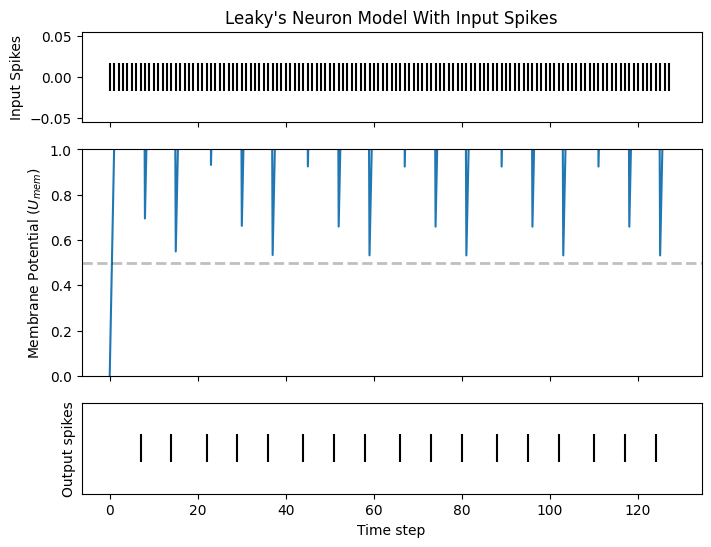

In [31]:
# Declaring the input vector. Ensure it will always be the same setting the seed to static
num_steps = 128
torch.manual_seed(123)
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps,1)) * 1)

#spk_in = torch.ones(128, dtype=torch.int32)

lif = snn.Leaky(beta=0.9, threshold = 5)

# Initialize inputs and outputs
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

start_time = time.time()
for step in range(num_steps):
  spk_out, mem = lif(spk_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)
end_time = time.time()
# neuron with halved threshold

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

print(f"Simulation took {(end_time - start_time) * 10**6} microseconds")
plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title = "Leaky's Neuron Model With Input Spikes")